# Prediction of car prices based on their condition


![image](https://storage.googleapis.com/kaggle-datasets-images/1479517/2444963/1aaa3760e7dd34a87af175482c1514ae/dataset-cover.jpg?t=2021-07-21-09-56-46)

Data extracted from kaggle. Click [here](https://www.kaggle.com/datasets/sidharth178/car-prices-dataset) to see it.

## Table of Content:
1. [First view to data](#section1)
2. [Select and Train a Models](#section2)

## First view at the data <a id="section1"></a>

In [1]:
import os
if 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
    print("Running on Kaggle")
    data_dir = "../input/car-prices-dataset"
else:
    print("Not running on Kaggle")
    data_dir = "archive"

Not running on Kaggle


In [2]:
import numpy as np
import pandas as pd

# We already have the data partitioned
df_train = pd.read_csv(f"{data_dir}/train.csv")
print(f"Shape: {df_train.shape}")
df_train.head()

Shape: (19237, 18)


,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [3]:
df_train.isna().sum() # Below we can see the data is extremely clean; this is not common at all

ID                  0
Price               0
Levy                0
Manufacturer        0
Model               0
Prod. year          0
Category            0
Leather interior    0
Fuel type           0
Engine volume       0
Mileage             0
Cylinders           0
Gear box type       0
Drive wheels        0
Doors               0
Wheel               0
Color               0
Airbags             0
dtype: int64

In [4]:
import re

def clean(df):
    df = df.copy()
    df["Leather interior"] = df["Leather interior"].apply(lambda x: 1 if x=="Yes" else 0) # Numeric atributes are much easier to manage
    df.drop(["ID", "Levy"], axis=1, inplace=True)
    df["Engine volume"] = df["Engine volume"].apply(lambda x: float(x.split(" ")[0]))
    df["Mileage"] = df["Mileage"].apply(lambda x: float(x.split(" ")[0]))
    df["Doors"] = df["Doors"].apply(lambda x: np.int64(re.findall(r'\d+', x)[0]))
    return df

print("We have a {:.2%} of null levies".format(df_train['Levy'].apply(lambda x: x=='-').sum() / df_train.shape[0]))
print("It is very high, so we won't be using that feature")

df_train = clean(df_train)
df_train.info()

We have a 30.25% of null levies
It is very high, so we won't be using that feature
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Price             19237 non-null  int64  
 1   Manufacturer      19237 non-null  object 
 2   Model             19237 non-null  object 
 3   Prod. year        19237 non-null  int64  
 4   Category          19237 non-null  object 
 5   Leather interior  19237 non-null  int64  
 6   Fuel type         19237 non-null  object 
 7   Engine volume     19237 non-null  float64
 8   Mileage           19237 non-null  float64
 9   Cylinders         19237 non-null  float64
 10  Gear box type     19237 non-null  object 
 11  Drive wheels      19237 non-null  object 
 12  Doors             19237 non-null  int64  
 13  Wheel             19237 non-null  object 
 14  Color             19237 non-null  object 
 15  Airb

In [5]:
df_train.describe()

,Price,Prod. year,Leather interior,Engine volume,Mileage,Cylinders,Doors,Airbags
count,1.923700e+04,19237.000000,19237.000000,19237.000000,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,1.855593e+04,2010.912824,0.725373,2.307990,1.532236e+06,4.582991,3.925872,6.582627
std,1.905813e+05,5.668673,0.446338,0.877805,4.840387e+07,1.199933,0.403399,4.320168
min,1.000000e+00,1939.000000,0.000000,0.000000,0.000000e+00,1.000000,2.000000,0.000000
25%,5.331000e+03,2009.000000,0.000000,1.800000,7.013900e+04,4.000000,4.000000,4.000000
50%,1.317200e+04,2012.000000,1.000000,2.000000,1.260000e+05,4.000000,4.000000,6.000000
75%,2.207500e+04,2015.000000,1.000000,2.500000,1.888880e+05,4.000000,4.000000,12.000000
max,2.630750e+07,2020.000000,1.000000,20.000000,2.147484e+09,16.000000,5.000000,16.000000


In [6]:
import matplotlib.pyplot as plt

Y = df_train.select_dtypes(include = ["float64", "int64"])

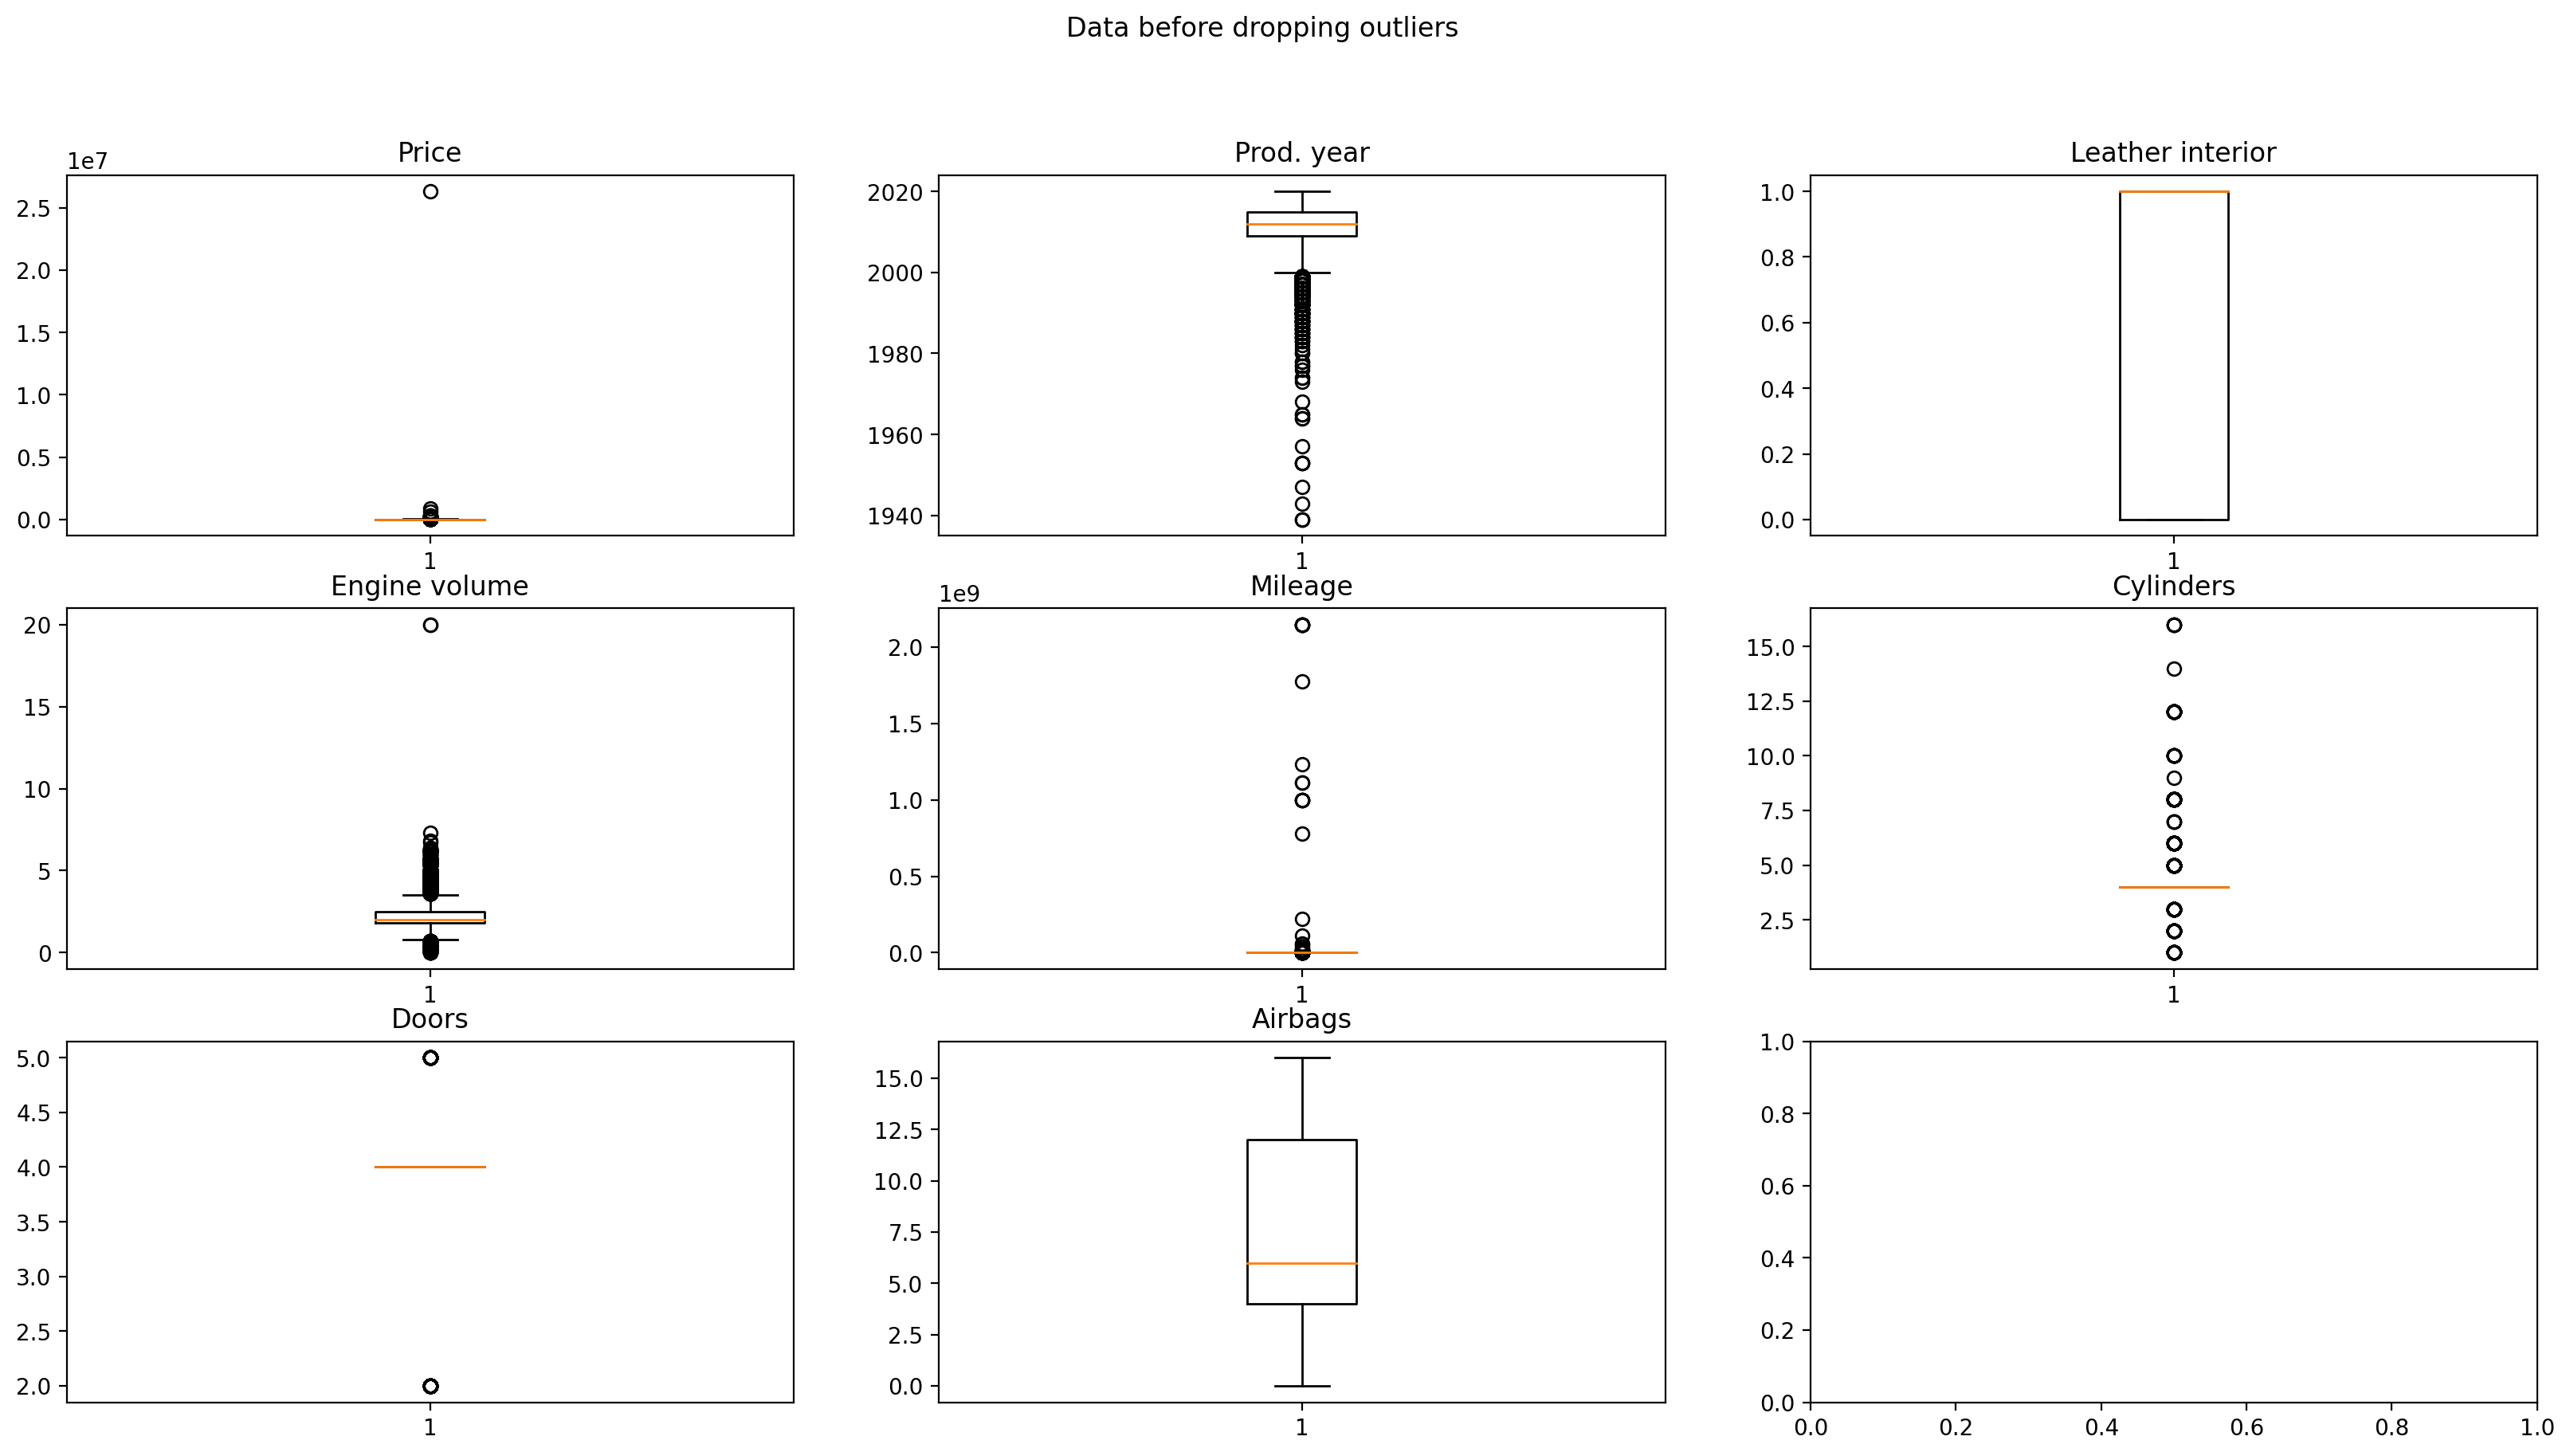

In [7]:
fig, axs = plt.subplots(3, 3)

fig.suptitle("Data before dropping outliers")
fig.set_dpi(200)
fig.set_size_inches(20, 10)
for index, column in enumerate(Y.columns):
    axs[int(index/3)][index%3].boxplot(Y[column])
    axs[int(index/3)][index%3].set_title(column)

We can appreciate various outliers in *Price* and *Engine Volume*. Let's drop them

In [8]:
#df_train.drop(index=[16983, 17777, 2357], inplace=True) # A 26 million dollars car, probabbly a typo, is messing up, so we drop it. Also 2 other extreme values
df_train.iloc[2357]
df_train.drop(df_train[(df_train["Price"]>4e5) | (df_train["Engine volume"]>10)].index, inplace=True)

Y = df_train.select_dtypes(include = ["float64", "int64"])

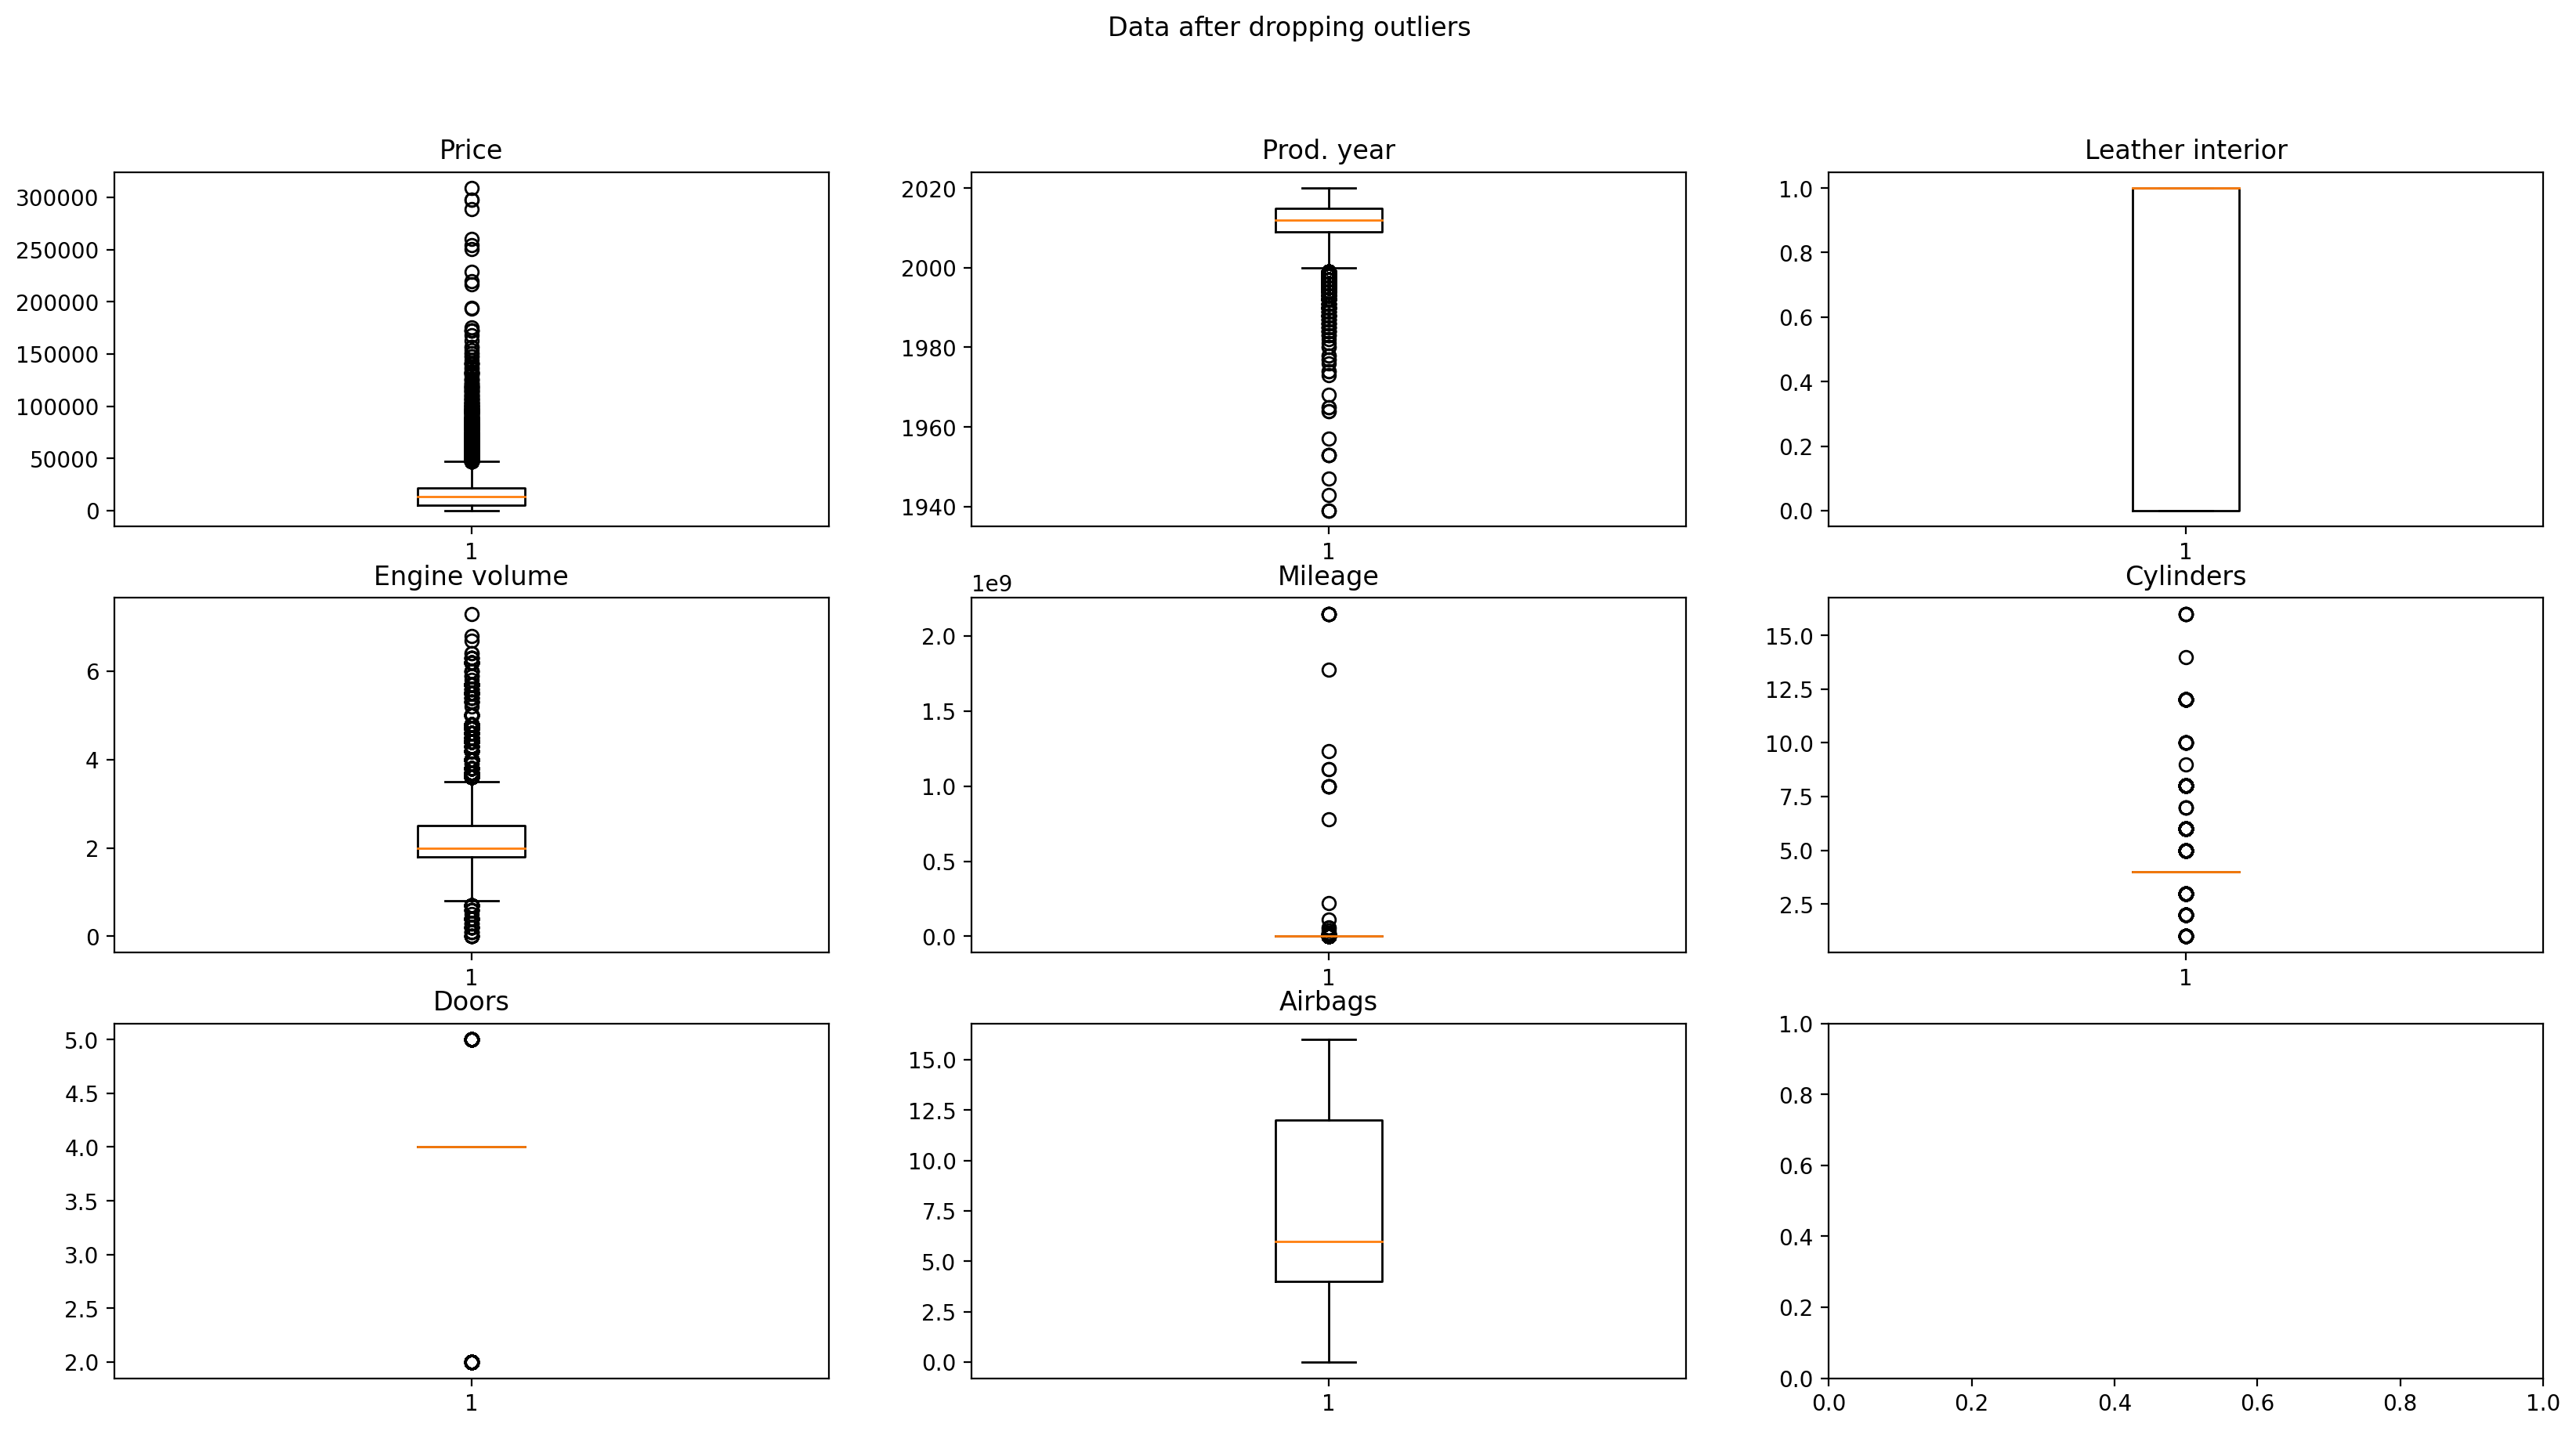

In [9]:
fig, axs = plt.subplots(3, 3)

fig.suptitle("Data after dropping outliers")
fig.set_dpi(200)
fig.set_size_inches(20, 10)

for index, column in enumerate(Y.columns):
    axs[int(index/3)][index%3].boxplot(Y[column])
    axs[int(index/3)][index%3].set_title(column)

This already looks like a much cleaner dataset. We could drop a lot of data that seems to be outlier, but we'll use all the data for the moment and worry later

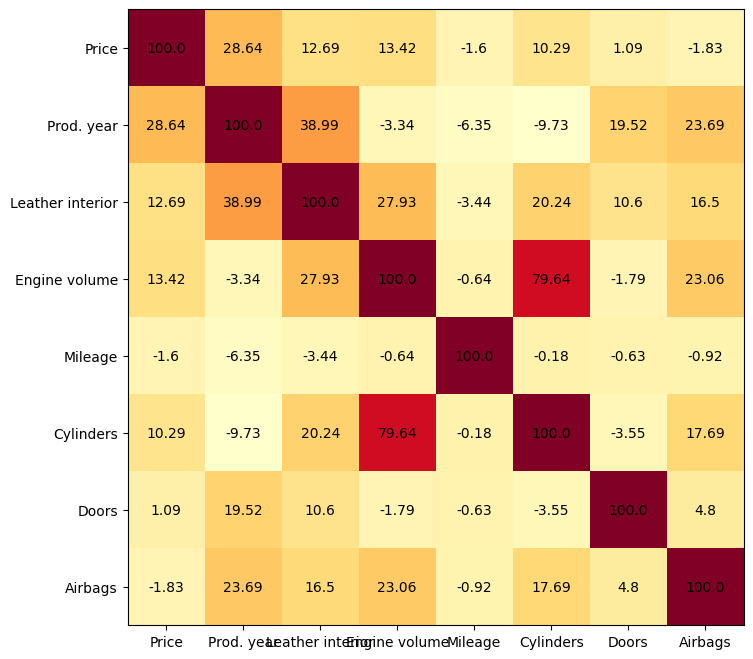

In [10]:
fig, ax = plt.subplots(figsize = (Y.shape[1], Y.shape[1]))
fig = plt.imshow(Y.corr(), cmap = "YlOrRd")
ax.set_xticks(range(Y.shape[1]))
ax.set_xticklabels(Y.axes[1])
ax.set_yticks(range(Y.shape[1]))
ax.set_yticklabels(Y.axes[1])
for (j,i),label in np.ndenumerate((Y.corr()*100).round(2)):
    ax.text(i,j,label,ha='center',va='center')
plt.show()

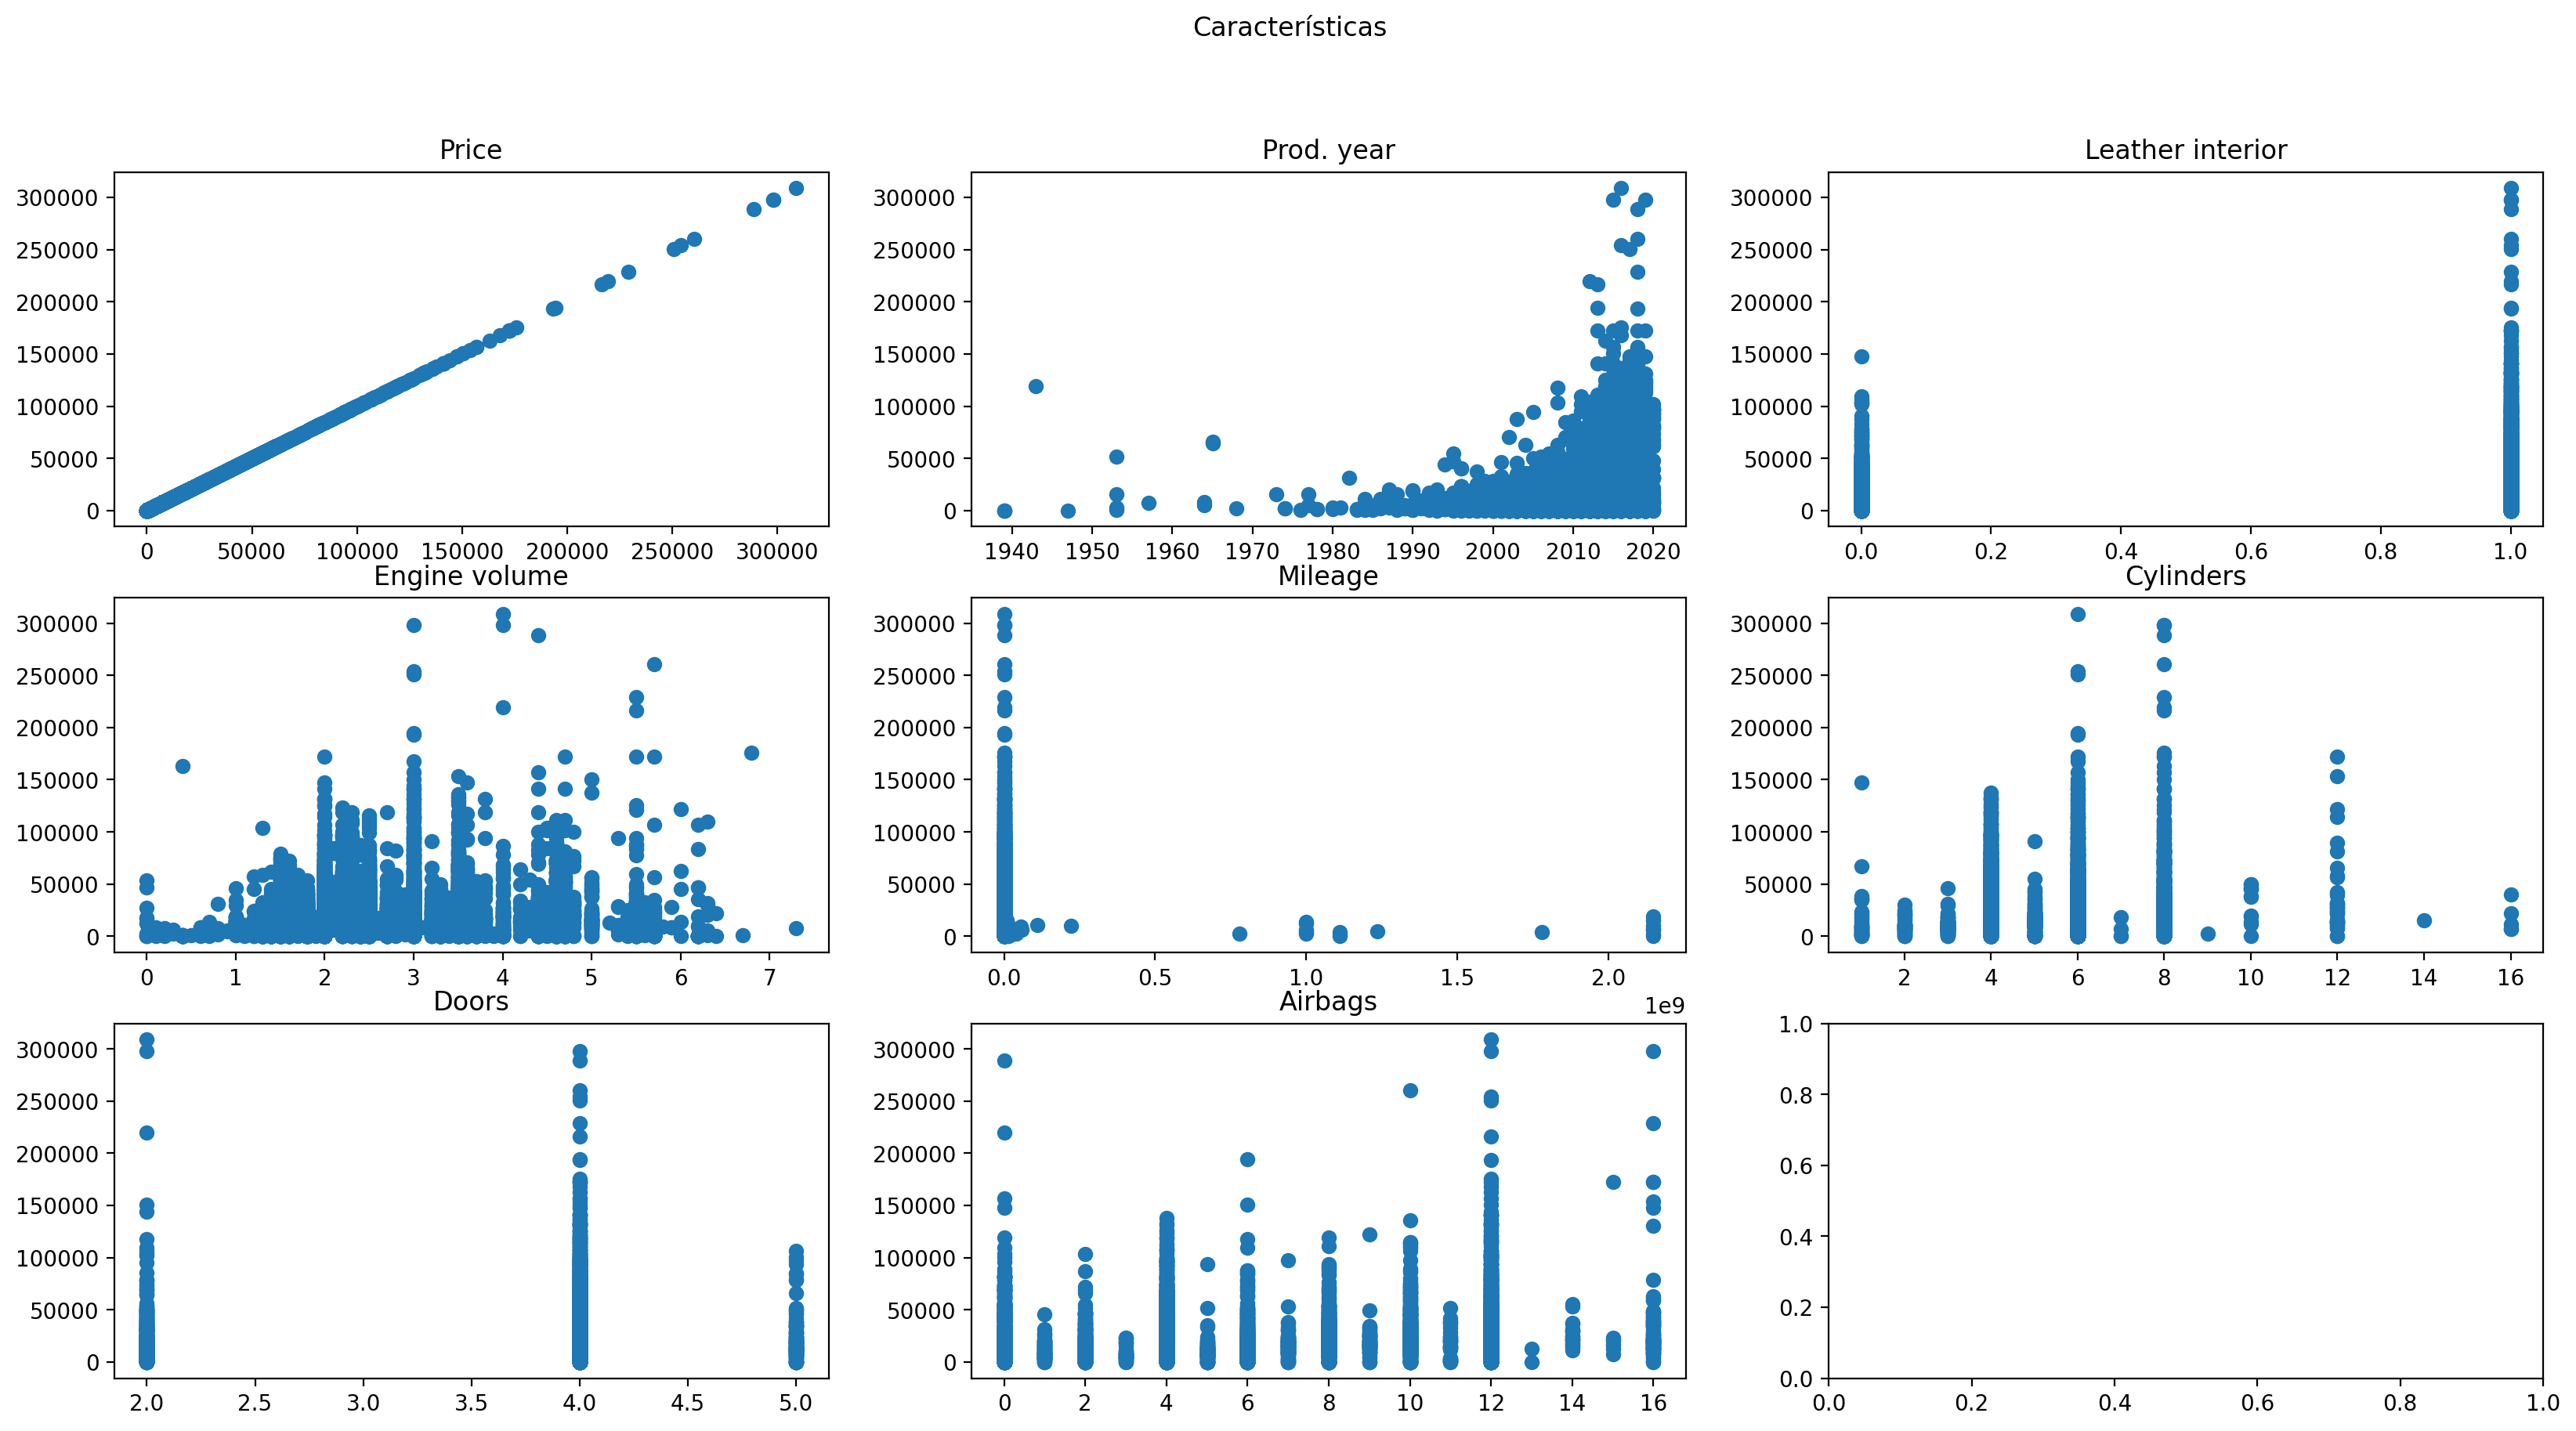

In [11]:
fig, axs = plt.subplots(3, 3)

fig.suptitle("Características")
fig.set_dpi(200)
fig.set_size_inches(20, 10)

for index, column in enumerate(Y.columns):
    axs[int(index/3)][index%3].scatter(Y[column], Y["Price"])
    axs[int(index/3)][index%3].set_title(column)

In [12]:
X_train = df_train[df_train.columns.drop(["Price"])].copy()
Y_train = df_train["Price"].copy()

### We first construct the Pipeline to prepare the data

In [13]:
transf_type = {"numeric": X_train.select_dtypes(include = ["float64", "int64"]).columns,
                "cat_onehot": X_train.select_dtypes(exclude = ["float64", "int64"]).columns} # Mileage first needs to be cleaned and later treated as a numeric attribute

In [14]:
from sklearn.preprocessing import OneHotEncoder
        
onehot_encoder = OneHotEncoder()
X_train_encoded = onehot_encoder.fit_transform(X_train[transf_type["cat_onehot"]])


print(X_train_encoded.toarray())
print(f"\nShape: {X_train_encoded.shape}. That means we start working with more than 1600 dimensions.\n")
for i, j in zip(transf_type["cat_onehot"], onehot_encoder.categories_):
    print(f"{i}: {j}")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]

Shape: (19232, 1695). That means we start working with more than 1600 dimensions.

Manufacturer: ['ACURA' 'ALFA ROMEO' 'ASTON MARTIN' 'AUDI' 'BENTLEY' 'BMW' 'BUICK'
 'CADILLAC' 'CHEVROLET' 'CHRYSLER' 'CITROEN' 'DAEWOO' 'DAIHATSU' 'DODGE'
 'FERRARI' 'FIAT' 'FORD' 'GAZ' 'GMC' 'GREATWALL' 'HAVAL' 'HONDA' 'HUMMER'
 'HYUNDAI' 'INFINITI' 'ISUZU' 'JAGUAR' 'JEEP' 'KIA' 'LANCIA' 'LAND ROVER'
 'LEXUS' 'LINCOLN' 'MASERATI' 'MAZDA' 'MERCEDES-BENZ' 'MERCURY' 'MINI'
 'MITSUBISHI' 'MOSKVICH' 'NISSAN' 'OPEL' 'PEUGEOT' 'PONTIAC' 'PORSCHE'
 'RENAULT' 'ROLLS-ROYCE' 'ROVER' 'SAAB' 'SATURN' 'SCION' 'SEAT' 'SKODA'
 'SSANGYONG' 'SUBARU' 'SUZUKI' 'TESLA' 'TOYOTA' 'UAZ' 'VAZ' 'VOLKSWAGEN'
 'VOLVO' 'ZAZ' 'სხვა']
Model: ['09-Mar' '100' '100 NX' ... 'macan S' 'tC' 'xD']
Category: ['Cabriolet' 'Coupe' 'Goods wagon' 'Hatchback' 'Jeep' 'Limousine'
 'Microbus' 'M

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # No es necesario porque no hay nulos, pero está bien tenerlo
    ('std_scaler', StandardScaler()),
    ])

num_pipeline.fit_transform(X_train[transf_type["numeric"]])

array([[-0.16094822,  0.61533567,  1.39081088, ...,  1.18152403,
         0.1836387 ,  1.25391273],
       [ 0.01548567, -1.62512924,  0.80844985, ...,  1.18152403,
         0.1836387 ,  0.32795233],
       [-0.86668376, -1.62512924, -1.17157763, ..., -0.48579593,
         0.1836387 , -1.06098826],
       ...,
       [-0.16094822,  0.61533567, -0.3562722 , ..., -0.48579593,
         0.1836387 , -0.59800806],
       [-0.69024988,  0.61533567, -0.3562722 , ..., -0.48579593,
         0.1836387 , -0.59800806],
       [ 0.19191956,  0.61533567,  0.10961662, ..., -0.48579593,
         0.1836387 ,  1.25391273]])

In [16]:
from sklearn.compose import ColumnTransformer

def get_X_prepared(exclude_columns):
    # Erase some columns for efficient purpouses

    X_train_excluded = X_train.copy()
    X_train_excluded.drop(exclude_columns, axis=1, inplace=True)

    transf_type_excluded = transf_type.copy()
    transf_type_excluded["cat_onehot"] = transf_type["cat_onehot"].drop(labels=exclude_columns)
    
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, transf_type["numeric"]),
        ("cat", OneHotEncoder(), transf_type_excluded["cat_onehot"]),
    ])
    return full_pipeline.fit_transform(X_train_excluded)

X_prepared = get_X_prepared(["Model", "Category", "Fuel type", "Gear box type", "Drive wheels", "Color", "Manufacturer", "Wheel"])

X_prepared.shape

(19232, 7)

## Select and Train Models <a id="section2"></a>

### Polynomial Regression

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def get_polynomial_regression(degree):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False) # degree=1 => LinearRegression
    std_scaler = StandardScaler(with_mean=False)
    lin_reg = LinearRegression()

    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    return polynomial_regression

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(ax, model, X, y, degree):
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    train_errors, val_errors = [], []
    for m in np.arange(10000, len(x_train) + 1, step=200):
        model.fit(x_train[:m], y_train[:m]) # Many models save the previously trained part
        y_train_predict = model.predict(x_train[:m])
        y_val_predict = model.predict(x_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    ax.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train", scalex=200)
    # plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    # plt.plot(np.abs(np.sqrt(train_errors)-np.sqrt(val_errors)), "grey",linewidth=3, label="diff")
    ax.legend(loc="upper right", fontsize=14)
    ax.set_title(f"RMSE, deg={degree}", fontsize=14)

In [19]:
fig, axs = plt.subplots(2, 2)

fig.suptitle("Learning curves for different degrees")
fig.set_dpi(200)
fig.set_size_inches(20, 10)

for i, degree in zip(range(4), [1, 2, 3, 4]):
    plot_learning_curves(axs[int(i/2)][i%2], get_polynomial_regression(degree), X_prepared, Y_train, degree)

In [ ]:
# It is very inneficient to use a polynomial regression of high degree, but the error seems to decrease. So we will use gradient descent
from sklearn.linear_model import SGDRegressor
def get_SGDpolynomial_regression(degree):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False) # degree=1 => LinearRegression
    std_scaler = StandardScaler(with_mean=False)
    lin_reg = SGDRegressor(tol=1e-3, penalty=None, random_state=42)

    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    return polynomial_regression

In [ ]:
X_prepared_complete = get_X_prepared(["Model", "Category", "Fuel type", "Gear box type", "Drive wheels", "Color", "Wheel"]) # Same as before but including Manufacturer
X_prepared_complete.shape

(19232, 71)

In [64]:
fig, axs = plt.subplots(2, 2)

fig.suptitle("Learning curves for different degrees")
fig.set_dpi(200)
fig.set_size_inches(20, 10)

for i, degree in zip(range(4), [1, 2, 3, 4]):
    plot_learning_curves(axs[int(i/2)][i%2], get_SGDpolynomial_regression(degree), X_prepared_complete.toarray(), Y_train, degree)

## License

This Jupyter Notebook and its contents are licensed under the terms of the GNU General Public License Version 2 as published by the Free Software Foundation. The full text of the license can be found at: https://www.gnu.org/licenses/gpl-2.0.html

Copyright (c) 2023, Joaquín Mateos Barroso

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program. If not, see https://www.gnu.org/licenses/ for a list of additional licenses.